In [1]:
import numpy as np
from scipy.integrate import quad
from scipy import constants
import matplotlib.pyplot as plt
%matplotlib inline

pc_to_cm = 3.085677581e18 # cm

Mjupiter = 2e30
Msun = 2e33
Rjupiter = 6.9911e9 # cm
AU = 1.495978707e13 # cm
Rydberg_eV = 13.6 # eV
eV_to_Joule = 1.6e-19
eV_to_erg = eV_to_Joule * 1e7
Rydberg_erg = Rydberg_eV * eV_to_erg # erg

In [2]:
# cgs unit
from scipy import constants
CC = constants.c*1e2
HH = constants.h*1e7
KK = constants.k*1e7
GG = constants.g*1e2
RR = constants.R*1e7
NA = constants.N_A
SIGMA = constants.sigma*1e3
AMU = 1.661e-24

In [3]:
def planck(wl, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    temp, = args
    fac = HH * CC / (wl * KK * temp)
    return (2.0 * HH * CC**2 / (wl**5)) * (1. / (np.exp(fac) - 1.))

In [4]:
def planck_dIdnu(nu, *args):
    """
    Returns the Planck function evaluated at wavelength wl and temperature temp.
    """
    nu = np.array(nu)
    temp, = args
    fac = HH * nu / (KK * temp)
    return (2.0 * HH * nu**3 / (CC**2)) * (1. / (np.exp(fac) - 1.))

In [5]:
def planck_photon(wl, *args):
    """
    Returns the thermal intensity of photons at wavelength wl and temperature temp.
    """
    wl = np.array(wl)
    energy_intensity = planck(wl, *args)
    energy_per_photon = HH * CC / wl
    return energy_intensity / energy_per_photon

In [6]:
wls = [1.e-6, 2.e-6]
temp = 300.
print planck(wls, temp)
print planck_photon(wls, temp)

[ 0.  0.]
[ 0.  0.]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [7]:
# check with Solar Constant
Rsun_to_AU = 0.0046
print quad(planck, 0.01e-4, 5.0e-4, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi


print quad(planck_dIdnu, 3e13, 3e+18, args=(5800.0,))[0]*Rsun_to_AU**2*np.pi

1350778.498
1356840.56849


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [8]:
# mass, orbitMj = 1.0
Mp = 10 * Mjupiter
orbit = 5.0 # AU

# accretion temperature
# DSS comment shouldn't it be 2e5, not 1e5?
def Tacc_fn(Mplanet):
    """
    Returns accretion temperature in K
    From eq. 11 of Spiegel & Madhusudhan 2012
    """
    return 2e5 * (Mplanet / Mjupiter) # K

# accretion luminosity
# DSS COMMENT: What should Mdot be?
def Luminosity_fn(Mplanet, Mdot=1e-8, Mstar=Msun):
    """
    Returns X-ray luminosity in erg/s
    From eq. 9 of Spiegel & Madhusudhan 2012
    """
    ll = 1e29 * (Mplanet / (10*Mjupiter))**3 * (Mdot / 1e-7) * (Mstar/Msun)**(-2)
    return ll

# "class B" recombination rate
def beta_fn(Mplanet, TT=1e4):
    """
    Returns beta from ...?
    """
    #2.74e-14 * (Mp/Mjupiter)**(-3.0/4.0) # cm^3 / sec
    # This seems useful?
    # http://www.astro.ncu.edu.tw/~wchen/Courses/ISM/07.Photoionization.pdf
    return 2.6e-13 * (TT / 1e4)**(-3./4.)

Tacc = Tacc_fn(Mp)
Luminosity = Luminosity_fn(Mp)
beta = beta_fn(Mp) # what's the right temperature to use?

In [9]:
planck_integrated = quad(planck, 0, 1.0e-4, args=(Tacc))[0]*np.pi
print planck_integrated

9.07259602324e+20


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [10]:
# denoting that surface area by "surface", 
###  surface * planck_integrated = Luminosity
###  surface =  Luminosity  / planck_integrated 

surface = Luminosity  / planck_integrated 
print surface

11022203.5395


In [11]:
Luminosity / ( SIGMA*Tacc**4 )

11022202.595843341

In [12]:
# Suppose photons with energy > 13.6 eV can ionize hydrogen
wl_ionize = HH * CC / (13.6 * eV_to_erg )
print wl_ionize*1e7, "[nm]"

91.2888641208 [nm]


In [13]:
# photons per second

source = surface * np.pi * quad(planck_photon, 0, wl_ionize, args=(Tacc))[0]
print source, "[s^-1]"

1.33901956184e+37 [s^-1]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: overflow encountered in exp


In [14]:
energy_per_photon = Tacc * KK
fudge_factor = 0.7 # completely arbitrary ... assuming we don't get 100% efficiency from collisional ionization
extra_factor = fudge_factor * (energy_per_photon / Rydberg_erg)
ndot_photons = Luminosity / energy_per_photon * extra_factor
print ndot_photons

3.21691176471e+38


In [15]:
# DSS COMMENT: I recommend not using "magic numbers"
# https://en.wikipedia.org/wiki/Magic_number_(programming)#Unnamed_numerical_constants
# I assume the 5.0 is AU?  I don't know what the 1e3 or the 1.8e6 are, though.
# It would be easier to follow the code if you replace all magic numbers with named constants.
# You can use some judgment here, like the "**(-2)" exponent doesn't need to be named,
# but I would name nearly everything else -- even obvious things like 13.6, which could be
# named "Rydberg" or something similar.


# YF temporary comment
# "1.8e6" comes from equation (18) of the manuscript 
density = 1.8e6 * (orbit / 5.0 )**(-2) # [cm^{-3}]

In [16]:
# DSS COMMENT: Isn't the calculation up to here in MKS, not cgs?  Do we want AU_to_m instead?
# Not sure about this one....
AU_to_cm = 1.49597870700e13
#stromgren = 3.0 / ( 4.0 * np.pi ) * ( source / ( density**2 * beta ) )**(1.0/3.0) / AU_to_cm
stromgren =  3. / (4. * np.pi) * (ndot_photons / ( density**2 * beta) )**(1.0/3.0) / AU_to_cm
print stromgren, "[AU]"

0.115778053092 [AU]


In [17]:
source / ndot_photons

0.04162437952240271

In [18]:
Rjupiter_to_AU = Rjupiter / AU
print Rjupiter_to_AU

0.000467326170305


In [19]:
stromgren / Rjupiter_to_AU

247.74570834866682

In [20]:
erg_s_cm_Hz_to_Jy = 1e23
surface * planck_dIdnu(1e9, 1e6) / ( 4. * np.pi * (100.0*pc_to_cm )**2 ) * erg_s_cm_Hz_to_Jy 


2.8302791425899941e-25

In [21]:
# from http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html eq. (4)

sigma_L = 6.3e-18 # in cm^2
sigma_H = sigma_L * (energy_per_photon / Rydberg_erg)**(-3.)
print sigma_H
mfp = 1. / (density * sigma_H) # mean free path
print 'Mean Free Path: %1.3f AU' % (mfp / AU)
print 'Mean Free Path: %1.3f Rjup' % (mfp / Rjupiter)
print 'Energy relative to Rydberg: %1.3f' % (energy_per_photon / Rydberg_erg)

3.0830287613e-21
Mean Free Path: 12.045 AU
Mean Free Path: 25775.340 Rjup
Energy relative to Rydberg: 12.690


# Considering the balance between inoization rate and recombination rate

http://ned.ipac.caltech.edu/level5/Madau6/Madau1_2.html


- $\alpha $ : ionization fraction
- $E_{\rm photon}$ : photon energy
- $T _e$ : electron temperature
- $\beta [T_e] $ : recombination rate $=2.6 \times 10^{-13} [{\rm cm^3/sec}]\cdot\left(\frac{T_e}{10^{4}} \right)^{-3/4}$
- $ \sigma _H [E_{\rm photon}] $ : cross section for X-ray, $= 6.3 \times 10^{-18} [{\rm cm}^2] \cdot \left( \frac{E_{\rm photon}}{E_{\rm Rydberg}} \right)^{-3} $

Assuming an equlibrium state (?),

$ \frac{S}{ 4 \pi r^2 } n ( 1-\alpha ) \sigma _H [E_{\rm photon}] = n^2 \alpha^2 \beta [T_e]  $

$\Rightarrow  \left( \frac{4 \pi r^2 n \beta [T_e] }{S \sigma_H[E_{\rm photon}]} \right) \alpha ^2 + \alpha - 1 = 0 $




In [22]:
T_e = 1e4
beta = beta_fn(Mp, TT=T_e)
print beta

2.6e-13


In [23]:
def ionization_fraction(radius):
    a = density*beta*4.*np.pi*radius**2/ndot_photons/sigma_H
    b = 1.
    c = -1.
    numerator = -1.*b + np.sqrt( b**2 - 4.*a*c )
    denominator = 2.*a
    return numerator/denominator

In [24]:
r_tics = np.linspace(1, 500, 500)
y_tics = ionization_fraction(r_tics*Rjupiter)

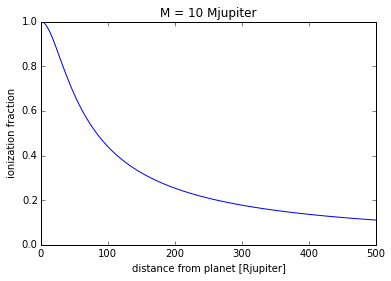

In [25]:
plt.plot(r_tics, y_tics)
plt.title('M = 10 Mjupiter')
plt.xlabel("distance from planet [Rjupiter]")
plt.ylabel("ionization fraction")
plt.ylim(0,1)
plt.show()